<h1>Arabic Auto Correction Using LSTMs and Transformers (●'◡'●)</h1>

<h2>Importing Libraries</h2>

In [2]:
import re
import nltk
import torch
import emoji
import random
import string 
import numpy as np
import pandas as pd 
import seaborn as sns
import tensorflow as tf
from datasets import Dataset
from collections import Counter
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from transformers import TrainingArguments, Trainer
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense
from transformers import AutoTokenizer, AutoModelForMaskedLM, DataCollatorForLanguageModeling
import warnings
warnings.filterwarnings("ignore")

<h2>Load and Explore the Dataset</h2>

In [3]:
# load train and validation data
df_train = pd.read_csv('/kaggle/input/arabic/train.csv')
df_val = pd.read_csv('/kaggle/input/arabic/valid.csv')

In [4]:
# view samples from training set
df_train.sample(5)

,correct,incorrect
10375,قسم حافظ الاسد دمشق ، وفصل ريفها عنها من بدايه...,قسم حافظ الاسد دمشق وفصل ريفها عنها من بدايه ح...
514,في البدايه ، نوصل لكم اخواننا القطريين ، والي ...,في البدايه نوصل لكم اخواننا القطريين والي امير...
10696,اعتقد ان التقرير لم يشمل اثرياء عرب ، علي الرغ...,اعتقد ان التقرير لم يشمل اثرياء عرب علي الرغم ...
2878,لسنا ضد دوله ازواد ، ولكن هل ازواد وحدها من سي...,لسنا ضد دوله ازواد ولكن هل ازواد وحدها من سيعل...
10174,يا شباب مدينه حلب هيا هبوا جميعا وانضموا الي ث...,يا شباب مدينه حلب هيا هبو جميعا وانضمو الي ثور...


In [5]:
# view samples from validation set
df_val.sample(5)

,correct,incorrect
1399,اما انت يا سيد فايق فنظامك اخذ وكاله الاستعمار...,اما انت يا سيد فايق فنظامك اخذ وكاله الاستعمار...
1352,اي حل واي اوهام يا اخي الكريم . . الوفاق حركه ...,اي حل واي خرابيط يا اخي الكريم . . الوفاق حركه...
2234,اهداء الي من يتشدقون بحريه التعبير والديموكارث...,اهداء الي من يتشدقون بالحريه التعبير والديموكا...
1000,كل الناس تتكلم عن مقتل المتمرد خليل ابراهيم ، ...,كل الناس تتكلم عن مقتل المتمرد خليل ابراهيم وا...
640,اذا كنا نحن نتابع الجزيره ، فهي لمصداقيتها . ....,اذا كنا نحن نتابع الجزيره فهو لمصداقيتها . . ا...


In [6]:
df_train.shape, df_val.shape

((18350, 2), (2293, 2))

In [7]:
# Concatenate train and validation sets
df = pd.concat([df_train, df_val])
df

,correct,incorrect
0,سبحان الله ، الحكام العرب سيموت علي الكرسي ليظ...,سبحان الله الحكام العرب سيموت علي الكرسي ليضهر...
1,النصر ات لا محال ان شاء الله . من يءمن بالله و...,النصر ات لا محال انشاء الله من يءمن بالله والي...
2,الي كل شخص يعتقد ان بشار الاسد سوف يخرج من سور...,الي كل شخص يعتقد ان بشار الاسد سوف يخرج من سور...
3,الاسد وعصابته - لحد الان - غير مستوعبين انه رح...,الاسد وعصابته لحد الان غير مستوعبين ان و رح ين...
4,النظام الاسدي تجاوز حتي ما فعله معمر القذافي ف...,النظام الاسدي تجاوز حتي ما فعله معمر القذافي ف...
...,...,...
2288,اعتقد ان اي مسلم من المستحيل ان يفعل هذا ، سوا...,اعتقد ان اي مسلم من المستحيل ان يفعل هذا سواء ...
2289,( . . وهو يصلح جدران بيته ويصبغها ، وحينما يست...,( . . وهو يصلح جدران بيته ويصبغها وحينما يستعص...
2290,انا استغرب ممن ينكر علي الجزيره ويصفها باثاره ...,انا استغرب ممن ينكر علي الجزيره ويصفها باثاره ...
2291,تصرف طبيعي ، اي انسان في امريكا يتعرض بالنقد ل...,تصرف طبيعي اي انسان في امريكا يتعرض بالنقد للي...


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 20643 entries, 0 to 2292
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   correct    20643 non-null  object
 1   incorrect  20643 non-null  object
dtypes: object(2)
memory usage: 483.8+ KB


In [9]:
df.isna().sum()

correct      0
incorrect    0
dtype: int64

In [10]:
df.duplicated().sum()

33

In [11]:
df.drop_duplicates(inplace=True)

In [12]:
incorrect_sentences = df['incorrect'].tolist()
correct_sentences = df['correct'].tolist()

for i in range(10):
    print(f"Sample {i+1}:\nIncorrect: {incorrect_sentences[i]}\n-------\nCorrect: {correct_sentences[i]}")
    print("____________________________________________________________________")

Sample 1:
Incorrect: سبحان الله الحكام العرب سيموت علي الكرسي ليضهر انه عنيد وقوي ، لوكان بشار يحب ارضه او شعبه لخرج من الحكم شفقه ورحمه ببلد ضاع ، هنا زال قناع هذا الرءيس اللذي خيب ظن شعبه والشعوب المسلمه ، كل مال السورين نفق في شراء سلاح ليقتل به ، شتانا وحكام اوربا الذين يتركون الكرسي لمجرد فتنه بسيطه لحبهم لبلدهم
-------
Correct: سبحان الله ، الحكام العرب سيموت علي الكرسي ليظهر انه عنيد وقوي . لو كان بشار يحب ارضه او شعبه ، لخرج من الحكم شفقه ورحمه ببلد ضاع . هنا زال قناع هذا الرءيس ، الذي خيب ظن شعبه والشعوب المسلمه ، كل مال السورين نفق في شراء سلاح ليقتل به ، شتان وحكام اوربا ، الذين يتركون الكرسي لمجرد فتنه بسيطه لحبهم لبلدهم .
____________________________________________________________________
Sample 2:
Incorrect: النصر ات لا محال انشاء الله من يءمن بالله واليوم الاخر . والمطلع علي قصص الانبياء يري ان النصر من الله وعلامات القيامه اتيه في تسلسل عجيب . ان تنصر الله ينصركم لا رجوع انما التغيير ات ليس من الرءساء انما من فوق سابع سماء
-------
Correct: النصر ات لا محال ان شاء الله 

<h2>Exploratory Data Analysis (EDA)</h2>

***To analyze word count, stopwords, and emoji usage in correct and incorrect sentences -> helping us understand error patterns and text quality before preprocessing***

In [13]:
stop_words = set(nltk.corpus.stopwords.words("arabic"))

def avg_word(sentence):
    words = sentence.split()
    if len(words) == 0:
        return 0
    return (sum(len(word) for word in words)/len(words))


df_features = pd.DataFrame({
    # Word counts
    'word_count_correct': df['correct'].apply(lambda x: len(str(x).split(" "))),
    'word_count_incorrect': df['incorrect'].apply(lambda x: len(str(x).split(" "))),

    # Stopword counts
    'stopwords_correct': df['correct'].apply(lambda x: len([w for w in x.split() if w in stop_words])),
    'stopwords_incorrect': df['incorrect'].apply(lambda x: len([w for w in x.split() if w in stop_words])),

    # Emoji counts
    'emoji_count_correct': df['correct'].apply(lambda x: emoji.emoji_count(x)),
    'emoji_count_incorrect': df['incorrect'].apply(lambda x: emoji.emoji_count(x)),

    # Average word length
    'avg_word_length_correct': df['correct'].apply(avg_word),
    'avg_word_length_incorrect': df['incorrect'].apply(avg_word)
})

In [14]:
df_features.head()

,word_count_correct,word_count_incorrect,stopwords_correct,stopwords_incorrect,emoji_count_correct,emoji_count_incorrect,avg_word_length_correct,avg_word_length_incorrect
0,65,59,12,8,0,0,3.723077,4.050847
1,54,45,10,10,0,0,3.444444,3.911111
2,66,57,7,7,0,0,3.424242,3.789474
3,70,62,10,10,0,0,3.871429,4.225806
4,66,64,11,11,0,0,4.015152,4.109375


In [15]:
df_features.describe()

,word_count_correct,word_count_incorrect,stopwords_correct,stopwords_incorrect,emoji_count_correct,emoji_count_incorrect,avg_word_length_correct,avg_word_length_incorrect
count,20610.000000,20610.000000,20610.000000,20610.000000,20610.0,20610.0,20610.000000,20610.000000
mean,58.722319,54.247210,9.336875,9.745706,0.0,0.0,4.096448,4.341099
std,18.524088,17.572836,4.537764,5.038992,0.0,0.0,0.378278,0.467289
min,6.000000,6.000000,0.000000,0.000000,0.0,0.0,1.181159,1.181159
25%,51.000000,47.000000,7.000000,7.000000,0.0,0.0,3.842105,4.038096
50%,57.000000,52.000000,9.000000,9.000000,0.0,0.0,4.088562,4.333333
75%,63.000000,58.000000,11.000000,12.000000,0.0,0.0,4.340000,4.644444
max,484.000000,461.000000,132.000000,132.000000,0.0,0.0,5.809524,7.928571


*Since the word counts in the 'correct' and 'incorrect' columns differ, we’ll create a new feature from the incorrect text to help the model better understand and correct the errors.*

<h2>Preprocessing</h2>

<h3>Clean Text</h3> 

In [13]:
punctuations = [
    ".", "#", "$", "//", "?", "=", "'", "_", "-", ";", "\\", "`", "؛", "<", ">", "(", ")", "*", "&", "^", 
    "%", "]", "[", ",", "ـ", "،", "/", ":", "؟", "'", "{", "}", "~", "|", "!", "”", "…", "“", "–", '+', '@', '"'
]

def clean_text(sentence: str):
    # Normalize Arabic characters
    sentence = sentence.replace('أ', 'ا').replace('إ', 'ا').replace('آ', 'ا').replace('ة', 'ه').replace('ى', 'ي')
    
    # Remove punctuations
    sentence = ''.join([char for char in sentence if char not in punctuations])

    # Remove non-Arabic characters
    sentence = ''.join([char for char in sentence if char in 'ابتثجحخدذرزسشصضطظعغفقكلمنهويءئؤىة '])


    # Remove numbers and extra spaces
    sentence = re.sub("\d+", " ", sentence)  
    sentence = re.sub('\s+', ' ', sentence)

    # Strip leading and trailing spaces
    sentence = sentence.strip()

    return sentence

In [14]:
text = "يجب أن أذاكر {NLP} جيداً لكي     احصل على A+ و 90 درجة /   "
cleaned_text = clean_text(text)
print(cleaned_text)

يجب ان اذاكر جيدا لكي احصل علي و درجه


In [15]:
df['correct'] = df['correct'].apply(lambda x: clean_text(x))

df.sample(5)

,correct,incorrect
15270,اتقدم باحر التعازي لقناه الجزيره ولعاءله الفقي...,اتقدم باحر التعازي لقناه الجزيره و لعاءله الفق...
815,يجب تعديل الدستور اولا خصوصا الفصل ملك المغرب ...,يجب تعديل الدستور اولا خصوصا الفصل 19 ، ملك ال...
564,اين هي القرارات مما يجري في البحرين من قبل الع...,اين هي القرارات مما يجري في البحرين من قبل الع...
1340,ابارك لهءلاء هذه الاموال اسال الله ان يضعوها ف...,ابارك لهءلاء . . هذه الاموال اسال الله ان يضعو...
14691,ان الله اقسم وقال فلا وربك لا يءمنون حتي يحكمو...,ان الله اقسم و قال : فلا وربك لا يءمنون حتي يح...


<h3>Add Noise in Text</h3>

In [21]:
def add_noise(sentence):
    words = sentence.split()
    
    if not words:
        return sentence

    word_idx = random.randint(0, len(words) - 1)
    word = list(words[word_idx])  # Convert the chosen word to a list of characters
    n = len(word)

    if n == 0:
        return sentence

    noise_type = random.choice(["add", "delete", "swap", "replace"])
    idx = random.randint(0, n - 1) if n > 1 else 0
    
    arabic_chars = "ابتثجحخدذرزسشصضطظعغفقكلمنهوي"

    if noise_type == "add":
        random_char = random.choice(arabic_chars)
        word.insert(idx, random_char)
    elif noise_type == "delete" and n > 1:
        word.pop(idx)
    elif noise_type == "swap" and idx < n - 1:
        word[idx], word[idx + 1] = word[idx + 1], word[idx]
    elif noise_type == "replace":
        word[idx] = random.choice(arabic_chars)

    
    words[word_idx] = ''.join(word)
    return ' '.join(words)

In [22]:
print(add_noise("احب لغتي العربية"))

احب غلتي العربية


In [23]:
df['incorrect'] = df['correct'].apply(add_noise)

In [24]:
df.head()

,correct,incorrect
0,سبحان الله الحكام العرب سيموت علي الكرسي ليظهر...,سبحان الله الحكام العرب سيموت علي الكرسي ليظهر...
1,النصر ات لا محال ان شاء الله من يءمن بالله وال...,النصر ات لا محال ان شاء الله من يءمن بالله وال...
2,الي كل شخص يعتقد ان بشار الاسد سوف يخرج من سور...,الي كل شخص يعتقد ان بشار الاسد سوف يخرج من سور...
3,الاسد وعصابته لحد الان غير مستوعبين انه رح ينق...,الاسد وعصابته لحد الان غير مستوعبين انه رح ينق...
4,النظام الاسدي تجاوز حتي ما فعله معمر القذافي ف...,النظام الاسدي تجاوز حتي ما فعله معمر القذافي ف...


In [26]:
incorrect_sentences = df['incorrect'].tolist()
correct_sentences = df['correct'].tolist()

for i in range(10):
    print(f"Sample {i+1}:\nIncorrect: {incorrect_sentences[i]}\n-------\nCorrect: {correct_sentences[i]}")
    print("____________________________________________________________________")

Sample 1:
Incorrect: سبحان الله الحكام العرب سيموت علي الكرسي ليظهر انه عنيد وقوي لو كان بشار يحب ارضه او شعبه لخرج من الحكم شفقه ورحمه ببلد ضاع هنا زال قناع هذا الرءيس الذي خيب ظن شعبه والشعوب المسلمه كل مال السورين نفق في شراء سلاح ليقتل به شتان وحكام اوربا انذين يتركون الكرسي لمجرد فتنه بسيطه لحبهم لبلدهم
-------
Correct: سبحان الله الحكام العرب سيموت علي الكرسي ليظهر انه عنيد وقوي لو كان بشار يحب ارضه او شعبه لخرج من الحكم شفقه ورحمه ببلد ضاع هنا زال قناع هذا الرءيس الذي خيب ظن شعبه والشعوب المسلمه كل مال السورين نفق في شراء سلاح ليقتل به شتان وحكام اوربا الذين يتركون الكرسي لمجرد فتنه بسيطه لحبهم لبلدهم
____________________________________________________________________
Sample 2:
Incorrect: النصر ات لا محال ان شاء الله من يءمن بالله واليوم الاخر والمطلع علي قصص الانبياء يري ان النصر من الله عولامات القيامه اتيه في تسلسل عجيب ان تنصروا الله ينصركم لا رجوع انما التغيير ات ليس من الرءساء انما من فوق سابع سماء
-------
Correct: النصر ات لا محال ان شاء الله من يءمن بالله واليوم الاخر و

<h3>Tokenizing Text</h3>

In [27]:
tokenizer = tf.keras.preprocessing.text.Tokenizer()
tokenizer.fit_on_texts(df['correct'])

In [28]:
# Convert texts to sequences
correct_sequences = tokenizer.texts_to_sequences(df['correct'])
incorrect_sequences = tokenizer.texts_to_sequences(df['incorrect'])

In [29]:
# Pad sequences to ensure uniform length
max_len = max(
    max(len(seq) for seq in correct_sequences),
    max(len(seq) for seq in incorrect_sequences)
)

correct_padded = tf.keras.preprocessing.sequence.pad_sequences(correct_sequences, maxlen=max_len, padding='post')
incorrect_padded = tf.keras.preprocessing.sequence.pad_sequences(incorrect_sequences, maxlen=max_len, padding='post')

In [30]:
print(f"Vocabulary size: {len(tokenizer.word_index)}")
print(f"Maximum sequence length: {max_len}")

Vocabulary size: 100808
Maximum sequence length: 394


<h2>Splitting Data into Training, Validation, and Test Sets</h2>

In [31]:
# Split data into temp(train+val) and test
X_temp, X_test, y_temp, y_test = train_test_split(incorrect_padded, correct_padded, test_size=0.1, random_state=42)

# Split temp(train+val) into train and val
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.2, random_state=42)

In [32]:
print(f"X_train shape: {X_train.shape}")
print(f"X_val shape: {X_val.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_val shape: {y_val.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (14839, 394)
X_val shape: (3710, 394)
X_test shape: (2061, 394)
y_train shape: (14839, 394)
y_val shape: (3710, 394)
y_test shape: (2061, 394)


<h2>LSTM Model</h2>

In [30]:
# Model architecture
input_layer = Input(shape=(max_len,))
embedding_output = Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=128)(input_layer)
encoder = LSTM(128, return_sequences=True)(embedding_output)
decoder = Dense(len(tokenizer.word_index) + 1, activation='softmax')(encoder)

auto_correct_model = Model(input_layer, decoder)

auto_correct_model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

In [31]:
auto_correct_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 394)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding_1 (Embedding)              │ (None, 394, 128)            │      12,912,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 394, 128)            │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 394, 100875)         │      13,012,875 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 26,056,459 (99.40 MB)

 Trainable params: 26,056,459 (99.40 MB)

 Non-trainable params: 0 (0.00 B)

In [33]:
# Model Training
history = auto_correct_model.fit(X_train, y_train,
                    validation_data=(X_val, y_val),
                    batch_size=16, epochs=10, callbacks=[early_stop])

Epoch 1/10
928/928 ━━━━━━━━━━━━━━━━━━━━ 640s 690ms/step - accuracy: 0.8735 - loss: 1.2802 - val_accuracy: 0.8766 - val_loss: 1.1080
Epoch 2/10
928/928 ━━━━━━━━━━━━━━━━━━━━ 648s 699ms/step - accuracy: 0.8795 - loss: 1.0684 - val_accuracy: 0.8894 - val_loss: 1.0223
Epoch 3/10
928/928 ━━━━━━━━━━━━━━━━━━━━ 650s 701ms/step - accuracy: 0.8936 - loss: 0.9563 - val_accuracy: 0.9037 - val_loss: 0.9099
Epoch 4/10
928/928 ━━━━━━━━━━━━━━━━━━━━ 651s 701ms/step - accuracy: 0.9078 - loss: 0.8136 - val_accuracy: 0.9138 - val_loss: 0.8213
Epoch 5/10
928/928 ━━━━━━━━━━━━━━━━━━━━ 651s 702ms/step - accuracy: 0.9194 - loss: 0.6874 - val_accuracy: 0.9202 - val_loss: 0.7574
Epoch 6/10
928/928 ━━━━━━━━━━━━━━━━━━━━ 651s 702ms/step - accuracy: 0.9301 - loss: 0.5784 - val_accuracy: 0.9249 - val_loss: 0.7096
Epoch 7/10
928/928 ━━━━━━━━━━━━━━━━━━━━ 652s 703ms/step - accuracy: 0.9391 - loss: 0.4891 - val_accuracy: 0.9267 - val_loss: 0.6767
Epoch 8/10
928/928 ━━━━━━━━━━━━━━━━━━━━ 652s 703ms/step - accuracy: 0.9476 -

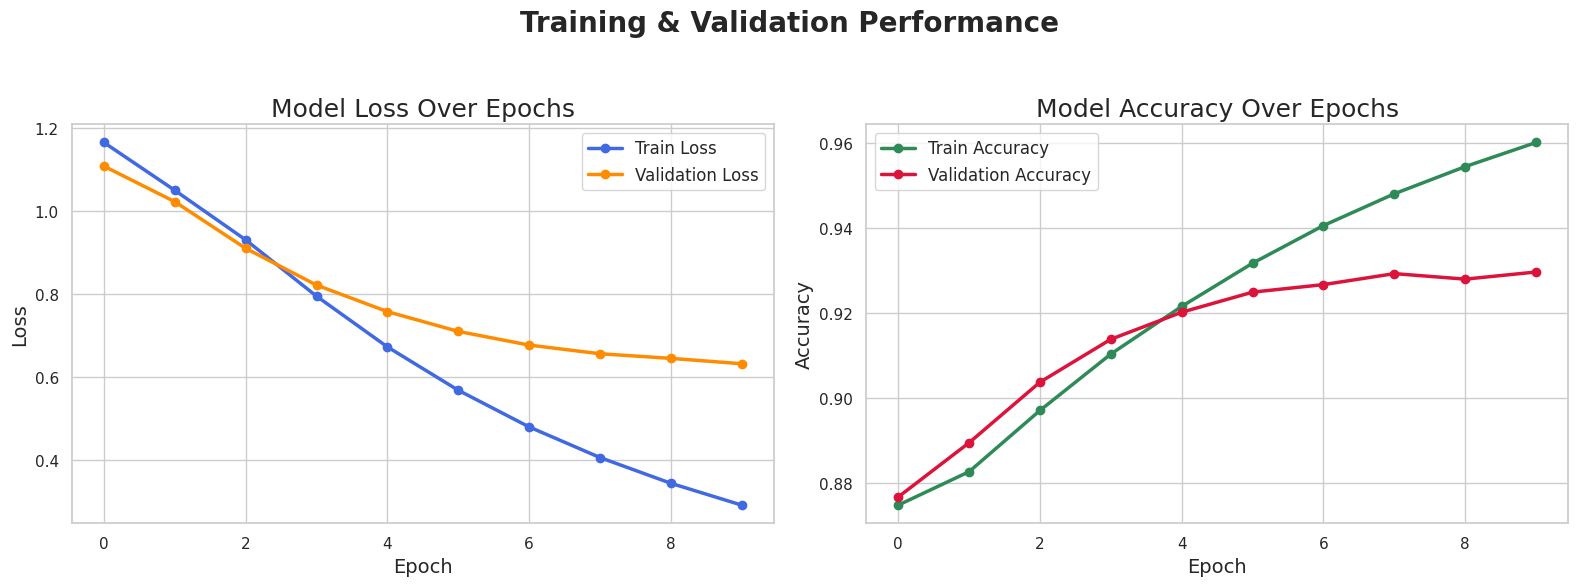

In [34]:
# Visualize Training History

sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (16, 6)
plt.rcParams["font.size"] = 14

fig, (ax1, ax2) = plt.subplots(1, 2)

# Plot Loss
ax1.plot(history.history['loss'], label='Train Loss', color='royalblue', linewidth=2.5, marker='o')
ax1.plot(history.history['val_loss'], label='Validation Loss', color='darkorange', linewidth=2.5, marker='o')
ax1.set_title('Model Loss Over Epochs', fontsize=18)
ax1.set_xlabel('Epoch', fontsize=14)
ax1.set_ylabel('Loss', fontsize=14)
ax1.legend(fontsize=12)
ax1.grid(True)

# Plot Accuracy
ax2.plot(history.history['accuracy'], label='Train Accuracy', color='seagreen', linewidth=2.5, marker='o')
ax2.plot(history.history['val_accuracy'], label='Validation Accuracy', color='crimson', linewidth=2.5, marker='o')
ax2.set_title('Model Accuracy Over Epochs', fontsize=18)
ax2.set_xlabel('Epoch', fontsize=14)
ax2.set_ylabel('Accuracy', fontsize=14)
ax2.legend(fontsize=12)
ax2.grid(True)

plt.suptitle("Training & Validation Performance", fontsize=20, weight='bold')
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


In [35]:
# Evaluate on Test Data
test_loss, test_accuracy = auto_correct_model.evaluate(X_test, y_test, batch_size=8)
print(f"\nTest Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

258/258 ━━━━━━━━━━━━━━━━━━━━ 60s 231ms/step - accuracy: 0.9295 - loss: 0.6330

Test Loss: 0.6195
Test Accuracy: 0.9306


In [37]:
# Save Model and Tokenizer
import pickle
auto_correct_model.save('arabic_auto_correction_model.h5')
with open('tokenizer.pkl', 'wb') as f:
    pickle.dump(tokenizer, f)

<h2>Twitter's twhin-bert-large Model</h2>

In [16]:
# Device Setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [17]:
# Base Model Initialization
tokenizer = AutoTokenizer.from_pretrained("Twitter/twhin-bert-large")
model = AutoModelForMaskedLM.from_pretrained("Twitter/twhin-bert-large").to(device)

tokenizer_config.json:   0%|          | 0.00/373 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.1M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/634 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.25G [00:00<?, ?B/s]

In [18]:
# Data Collator Setup
data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm_probability=0.15, return_tensors='pt')

In [19]:
# Creates word frequency dictionary from dataframe
def build_vocab_freq(dataframe):
    word_counter = Counter()
    for _, row in dataframe.iterrows():
        word_counter.update(row['correct'].split())
    return word_counter

In [20]:
# Generates sentences with rare words masked
def generate_masked_versions(text:str, vocab_freq:dict):
    words = text.split()
    masked_sentences = []

    for idx, word in enumerate(words):
        if vocab_freq.get(word, 0) == 0:
            modified_words = words.copy()
            modified_words[idx] = "<mask>"
            masked_sentences.append(" ".join(modified_words))
            
    return masked_sentences

In [21]:
# Combines original sentence with predicted words
def reconstruct_sentence(masked_sentences, predicted_words):
    final_sentence = []
    mask_positions = {}  # {sentence_idx: word_idx}

    # Locate all mask positions
    for sent_idx, sentence in enumerate(masked_sentences):
        for word_idx, word in enumerate(sentence.split()):
            if word == '<mask>':
                mask_positions[sent_idx] = word_idx

    # Build final sentence
    for sent_idx, sentence in enumerate(masked_sentences):
        words = sentence.split()
        for word_idx, word in enumerate(words):
            if word_idx in mask_positions.values():
                if predicted_words:  # Insert prediction if available
                    final_sentence.append(predicted_words.pop(0))
            elif word not in final_sentence:  # Avoid duplicates
                final_sentence.append(word)
                
    return ' '.join(final_sentence)

In [22]:
def tokenize_text(text_data):
    tokenized_output = tokenizer(text_data["correct"], truncation=True, padding="max_length", max_length=128)
    return {**tokenized_output}

In [24]:
new_df = df[['correct']]
new_df.head()

,correct
0,سبحان الله الحكام العرب سيموت علي الكرسي ليظهر...
1,النصر ات لا محال ان شاء الله من يءمن بالله وال...
2,الي كل شخص يعتقد ان بشار الاسد سوف يخرج من سور...
3,الاسد وعصابته لحد الان غير مستوعبين انه رح ينق...
4,النظام الاسدي تجاوز حتي ما فعله معمر القذافي ف...


In [25]:
# Generate vocabulary frequency dictionary
vocabulary_frequencies = build_vocab_freq(df)

# Convert DataFrame to HuggingFace Dataset (using first 2000 samples)
text_dataset = Dataset.from_pandas(new_df[:2000]) 

# Tokenize all texts in the dataset
tokenized_dataset = text_dataset.map(
    tokenize_text, 
    batched=True, 
    remove_columns=['correct']  # Remove original text column after tokenization
)

# Split into train/test sets
dataset = tokenized_dataset.train_test_split(
    test_size=0.2, 
    shuffle=True,
    seed=42
)

dataset

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['__index_level_0__', 'input_ids', 'attention_mask'],
        num_rows: 1600
    })
    test: Dataset({
        features: ['__index_level_0__', 'input_ids', 'attention_mask'],
        num_rows: 400
    })
})

In [ ]:
training_args = TrainingArguments(
    output_dir="./model",                  
    eval_strategy="epoch",            
    learning_rate=1e-5,                    
    num_train_epochs=2,                    
    weight_decay=5e-4,                     
    per_device_train_batch_size=4,         
    per_device_eval_batch_size=4,          
    push_to_hub=True,                     
    logging_steps=10,                      
    eval_steps=10,                         
    save_strategy="epoch",  
    report_to="none",   
    fp16=True,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset["train"],
    eval_dataset=dataset["test"],
    data_collator=data_collator,
    tokenizer=tokenizer,
)

In [27]:
trainer.train()

BertSdpaSelfAttention is used but `torch.nn.functional.scaled_dot_product_attention` does not support non-absolute `position_embedding_type` or `output_attentions=True` or `head_mask`. Falling back to the manual attention implementation, but specifying the manual implementation will be required from Transformers version v5.0.0 onwards. This warning can be removed using the argument `attn_implementation="eager"` when loading the model.


Epoch,Training Loss,Validation Loss
1,2.095800,2.092511
2,2.079100,1.996902


TrainOutput(global_step=400, training_loss=2.2036471557617188, metrics={'train_runtime': 608.6631, 'train_samples_per_second': 5.257, 'train_steps_per_second': 0.657, 'total_flos': 746159490662400.0, 'train_loss': 2.2036471557617188, 'epoch': 2.0})

In [28]:
trainer.save_model("/kaggle/working/model")

In [29]:
!zip -r /kaggle/working/model.zip /kaggle/working/model

  adding: kaggle/working/model/ (stored 0%)
  adding: kaggle/working/model/config.json (deflated 47%)
  adding: kaggle/working/model/checkpoint-400/ (stored 0%)
  adding: kaggle/working/model/checkpoint-400/optimizer.pt

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


 (deflated 7%)
  adding: kaggle/working/model/checkpoint-400/config.json (deflated 47%)
  adding: kaggle/working/model/checkpoint-400/trainer_state.json (deflated 81%)
  adding: kaggle/working/model/checkpoint-400/scaler.pt (deflated 60%)
  adding: kaggle/working/model/checkpoint-400/training_args.bin (deflated 51%)
  adding: kaggle/working/model/checkpoint-400/tokenizer.json (deflated 76%)
  adding: kaggle/working/model/checkpoint-400/model.safetensors
zip I/O error: No space left on device
zip error: Output file write failure (write error on zip file)


In [30]:
model = AutoModelForMaskedLM.from_pretrained("/kaggle/working/model").to(device)

In [33]:
def predict(input_text):
    # Tokenize input text
    tokenized_input = tokenizer(input_text, return_tensors='pt').to(device)

    # Mask the token corresponding to the masked word
    mask_token_index = torch.where(tokenized_input['input_ids'] == tokenizer.mask_token_id)

    # Generate predictions
    with torch.no_grad():
        outputs = model(**tokenized_input) # fORWARD PASS

    # Extract predicted token ID
    predicted_token_id = torch.argmax(outputs.logits[mask_token_index]).item()

    # Decode the predicted token ID
    predicted_token = tokenizer.decode(predicted_token_id)

    return predicted_token

In [34]:
def pipeline(input_text):
    arr_input = generate_masked_versions(input_text,words_freq)
    masked = []
    for sentence in arr_input:
        mask = predict(sentence)
        masked.append(mask)

    true_sentence = reconstruct_sentence(arr_input,masked)

    return true_sentence
# Get the vocab of the dataset
words_freq = build_vocab_freq(df)

In [86]:
# Example list of sentences
sentences = [
   "عار علككيم يا امه الاسسلام لعدم مساعدتكم لنا نحن السعب السوري الذي نقتل كل يوم بدم بارد وعلي مسمع العالم الاسلامي",
    "العرب لا يتعلمون من دروس التازيخ، كل حاكم يتسك بالسلطه حتي يهدم بلده بيديه.",
    "لا أمل في من باع نفسه للمصالح الشخصيه",
    "نحن احرار الامه الاسلاميه و لن نسمح بحدوث حرب في الوطن العر",
    "وززارة النربية والتعليم تعلن عن تعطبل الدراسة رسميا يوم السسبت نظرا للظروف الجوية الحالييه وحفاظا على المعلمون و الططلاب"
]

# Loop over each sentence
for input_text in sentences:
    true_sentence = pipeline(input_text)
    
    print('Incorrect Sentence:', input_text)
    print('Corrected Sentence:', true_sentence)
    print('-' * 50)


Incorrect Sentence: عار علككيم يا امه الاسسلام لعدم مساعدتكم لنا نحن السعب السوري الذي نقتل كل يوم بدم بارد وعلي مسمع العالم الاسلامي
Corrected Sentence: عار عليكم يا امه الاسلام لعدم مساعدتكم لنا نحن الشعب السوري الذي نقتل كل يوم بدم بارد وعلي مسمع العالم الاسلامي
--------------------------------------------------
Incorrect Sentence: العرب لا يتعلمون من دروس التازيخ، كل حاكم يتسك بالسلطه حتي يهدم بلده بيديه.
Corrected Sentence: العرب لا يتعلمون من دروس التاريخ كل حاكم يرغب بالسلطه حتي يهدم بلده .
--------------------------------------------------
Incorrect Sentence: لا أمل في من باع نفسه للمصالح الشخصيه
Corrected Sentence: لا خير في من باع نفسه للمصالح الشخصيه
--------------------------------------------------
Incorrect Sentence: نحن احرار الامه الاسلاميه و لن نسمح بحدوث حرب في الوطن العر
Corrected Sentence: نحن احرار الامه الاسلاميه و لن نسمح بحدوث حرب في الوطن العربي
--------------------------------------------------
Incorrect Sentence: وززارة النربية والتعليم تعلن عن تعطبل الدراسة 